## Decision Tree Classification of Hyperspectral Vegetation

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
fname = "../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../image_files/veg_00108.hdr...
reading ../image_files/veg_00108.raw...


In [3]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [5]:
print(min(cube.waves), max(cube.waves))


395.46 1008.06


In [7]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [8]:
# create array of indices

num_of_bins = 20
bin_ind = []

for i in range(0, num_of_bins):
    low_ind = int(i*int(cube_sub.shape[0]/num_of_bins))
    upp_ind = int(low_ind + int(cube_sub.shape[0]/num_of_bins))
    bin_ind.append([low_ind, upp_ind])
bin_ind[-1][-1] = cube_sub.shape[0]
    
print(bin_ind)

[[0, 42], [42, 84], [84, 126], [126, 168], [168, 210], [210, 252], [252, 294], [294, 336], [336, 378], [378, 420], [420, 462], [462, 504], [504, 546], [546, 588], [588, 630], [630, 672], [672, 714], [714, 756], [756, 798], [798, 848]]


In [9]:
cube_binned = np.zeros(shape=(cube_reshaped.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binned[:, i] = cube_reshaped[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binned.shape)

(2560000, 20)


In [10]:
# function to read coordinates from file

def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [11]:
# read manually selected coordinates files

# sky coordinates
sky_file = open("./sky_coordinates.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print(sky_coords.shape)

# vegetation coordinates
veg_file = open("./vegetation_coordinates.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print(veg_coords.shape)

# built coordinates
built_file = open("./built_coordinates.txt", "r")
built_coords = built_file.readlines()
built_file.close()
built_coords = np.array([point_from_string(line) for line in built_coords])
print(built_coords.shape)

(1000, 2)
(600, 2)
(1010, 2)


In [12]:
# split manually selected pixels to 80% training and 20% testing sets
import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*0.8)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(2).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*0.8)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("veg %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# built coordinates
built_ind = np.arange(built_coords.shape[0])
random.Random(0).shuffle(built_ind)
lim_ind = int(len(built_ind)*0.8)
built_train_ind = built_ind[:lim_ind]
built_test_ind = built_ind[lim_ind:]
print("built %d %d" % (len(built_train_ind), len(built_test_ind)))

sky 800 200
veg 480 120
built 808 202


In [13]:
cube_binned_full = cube_binned.reshape(cube_sub.shape[1], cube_sub.shape[2], num_of_bins)
print(cube_binned_full.shape)

(1600, 1600, 20)


In [14]:
cube_sky_train = cube_binned_full[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_binned_full[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print(cube_sky_train.shape, cube_sky_test.shape)

cube_veg_train = cube_binned_full[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_binned_full[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print(cube_veg_train.shape, cube_veg_test.shape)

cube_built_train = cube_binned_full[built_coords[built_train_ind[:], 0], built_coords[built_train_ind[:], 1], :]
cube_built_test = cube_binned_full[built_coords[built_test_ind[:], 0], built_coords[built_test_ind[:], 1], :]
print(cube_built_train.shape, cube_built_test.shape)

(800, 20) (200, 20)
(480, 20) (120, 20)
(808, 20) (202, 20)


In [15]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_veg_train, cube_built_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_veg_train.shape[0] + [2]*cube_built_train.shape[0]

cube_test = np.concatenate((cube_sky_test, cube_veg_test, cube_built_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_veg_test.shape[0] + [2]*cube_built_test.shape[0]


In [22]:
# Train decision tree

from sklearn import tree

dt = tree.DecisionTreeClassifier()
dTree = dt.fit(cube_train, cube_train_labels)

In [23]:
# test model with train set

testModel_train = dTree.predict(cube_train)

comparison_train = np.equal(testModel_train, cube_train_labels)
correct_train = np.where(comparison_train == True)[0]
accuracy_train = len(correct_train) * 100 / len(comparison_train)
print(accuracy_train)

100.0


In [24]:
# test model with test set

testModel = dTree.predict(cube_test)

comparison = np.equal(testModel, cube_test_labels)
correct = np.where(comparison == True)[0]
accuracy = len(correct) * 100 / len(comparison)
print(accuracy)

99.23371647509579


#### veg_00108 classification visualization

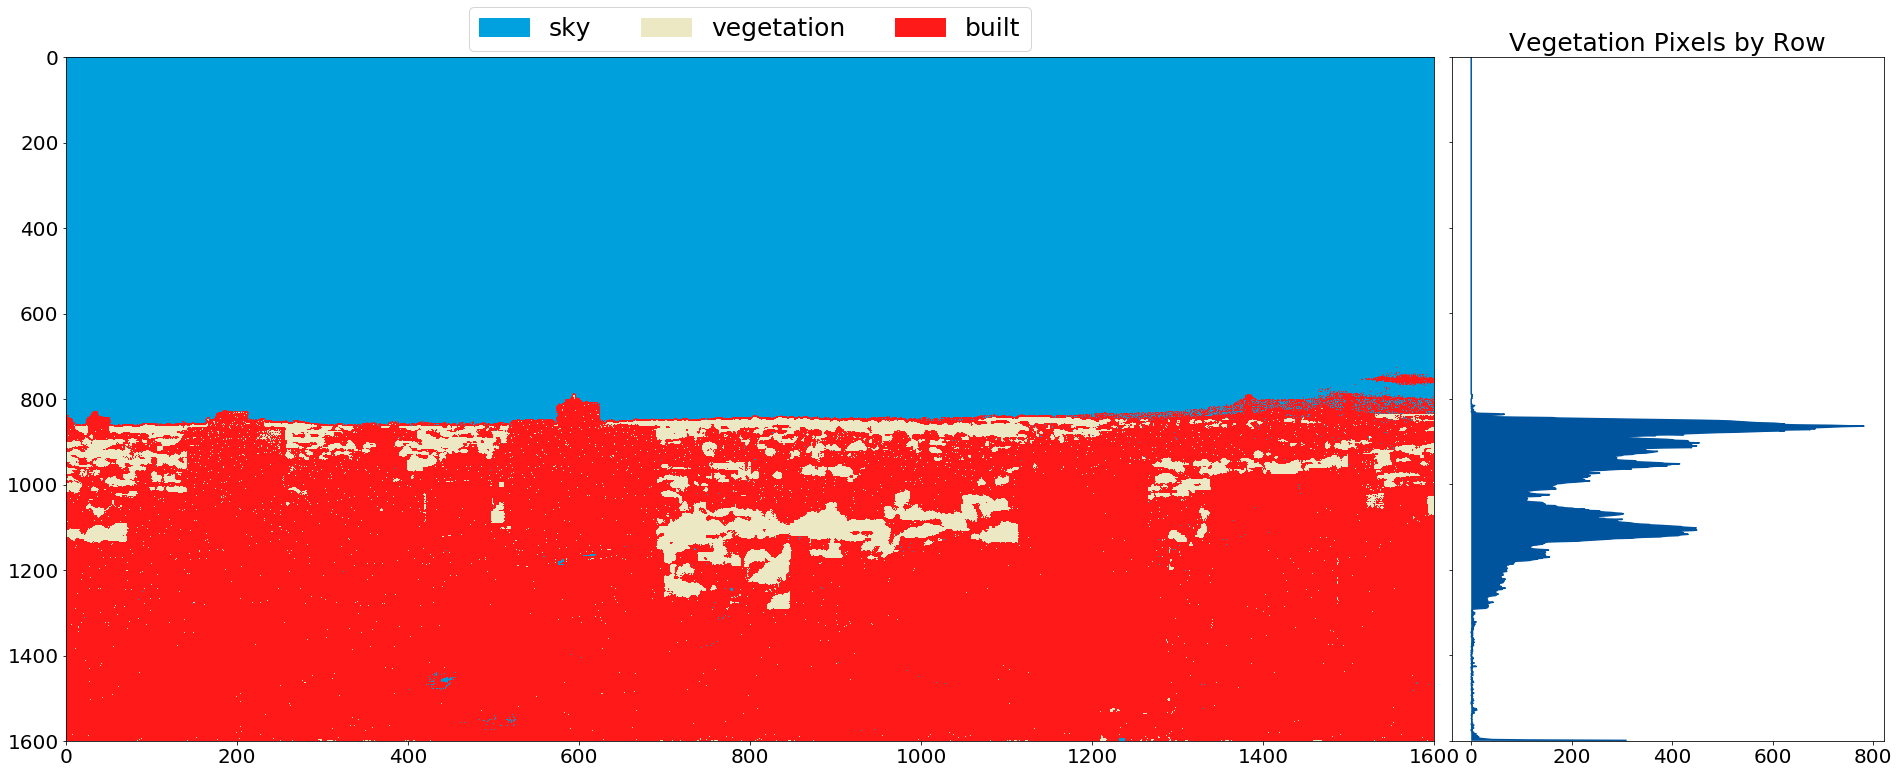

In [217]:
# classify entire binned cube

predictCube = dTree.predict(cube_binned)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
%matplotlib inline

predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 1)

t=1
cmap = {0:[0.0,0.63,0.87,t], 1:[0.93,0.91,0.77,t], 2:[1.0,0.1,0.1,t]}
labels = {0:'sky', 1:"vegetation", 2:"built"}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

#fig, ax = plt.subplots(1, figsize = (30, 10))
fig = plt.figure(1, figsize = (30, 10))
axImage = plt.axes([0.1,0.1,0.65,0.95])
axHist = plt.axes([0.75,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0.5,1), loc=9, borderaxespad=-2.0, prop={'size':25}, ncol=3)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])    
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
plt.show()
fig.savefig("./output/plots/1_decision_tree_classification_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [58]:
# write pixel labels to file
import pickle

filename = "./output/decision_tree_predict_00108"
outfile = open(filename, 'wb')
pickle.dump(predictCube, outfile)
outfile.close()

# read with:
#   infile = open(filename, 'rb')
#   predictCube = pickle.load(infile)
#   infile.close()

In [59]:
import collections, numpy

unique_sky, counts_sky = numpy.unique(predictCube_reshape[sky_coords[:,0], sky_coords[:,1]], return_counts=True)
counts_sky_norm = (counts_sky/sky_coords.shape[0])*100
sky_dict = dict(zip(unique_sky, counts_sky))
sky_dict_norm = dict(zip(unique_sky, counts_sky_norm))

unique_veg, counts_veg = numpy.unique(predictCube_reshape[veg_coords[:,0], veg_coords[:,1]], return_counts=True)
counts_veg_norm = (counts_veg/veg_coords.shape[0])*100
veg_dict = dict(zip(unique_veg, counts_veg))
veg_dict_norm = dict(zip(unique_veg, counts_veg_norm))

unique_blt, counts_blt = numpy.unique(predictCube_reshape[built_coords[:,0], built_coords[:,1]], return_counts=True)
counts_blt_norm = (counts_blt/built_coords.shape[0])*100
blt_dict = dict(zip(unique_blt, counts_blt))
blt_dict_norm = dict(zip(unique_blt, counts_blt_norm))

In [60]:
for i in range(0,3):
    if sky_dict.get(i) is None: sky_dict[i] = 0
    if sky_dict_norm.get(i) is None: sky_dict_norm[i] = 0
    if veg_dict.get(i) is None: veg_dict[i] = 0
    if veg_dict_norm.get(i) is None: veg_dict_norm[i] = 0
    if blt_dict.get(i) is None: blt_dict[i] = 0
    if blt_dict_norm.get(i) is None: blt_dict_norm[i] = 0

In [61]:
import pandas as pd

pixel_names = ['sky', 'vegetation', 'built']
df_test = pd.DataFrame([sky_dict, veg_dict, blt_dict], index=pixel_names)
df_test = df_test.transpose()
print(df_test)

   sky  vegetation  built
0  998           0      0
1    0         600      2
2    2           0   1008


In [62]:
import pandas as pd

pixel_names = ['sky', 'vegetation', 'built']
df_test_norm = pd.DataFrame([sky_dict_norm, veg_dict_norm, blt_dict_norm], index=pixel_names)
df_test_norm = df_test_norm.transpose()
print(df_test_norm)

    sky  vegetation     built
0  99.8         0.0   0.00000
1   0.0       100.0   0.19802
2   0.2         0.0  99.80198


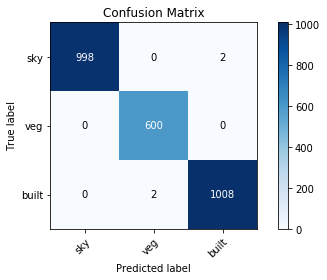

In [63]:
cm = np.array([df_test['sky'].values, df_test['vegetation'].values, df_test['built'].values])
classes = ['sky', 'veg', 'built']

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      xticklabels=classes, yticklabels=classes,
      title='Confusion Matrix',
      ylabel='True label',
      xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")
#fmt = '.2f'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j]),
               ha="center", va="center",
               color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()
fig.savefig("./output/plots/3_decision_tree_confusion_matrix_of_veg_00108.png")

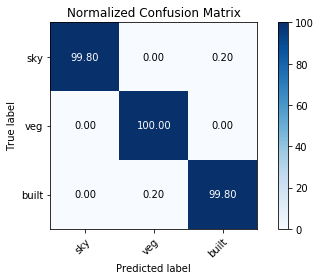

In [64]:
cm_norm = np.array([df_test_norm['sky'].values, df_test_norm['vegetation'].values, df_test_norm['built'].values])
classes = ['sky', 'veg', 'built']

fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm_norm.shape[1]),
      yticks=np.arange(cm_norm.shape[0]),
      xticklabels=classes, yticklabels=classes,
      title='Normalized Confusion Matrix',
      ylabel='True label',
      xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")
fmt = '.2f'
thresh = cm_norm.max() / 2
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
               ha="center", va="center",
               color="white" if cm_norm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()
fig.savefig("./output/plots/4_decision_tree_norm_confusion_matrix_of_veg_00108.png")

In [176]:
df_test_norm = df_test_norm.transpose()

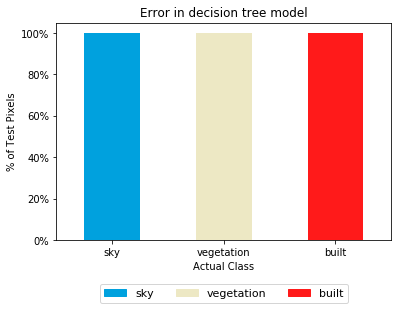

In [177]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

ax = df_test_norm.plot.bar(rot=0, stacked=True, color=[[0.0,0.63,0.87,1.0], [0.93,0.91,0.77,1.0], [1.0,0.1,0.1,1.0]])
formatter = FuncFormatter(lambda counts_veg_norm, pos: "%d%%" % (counts_veg_norm))
ax.yaxis.set_major_formatter(formatter)
plt.xlabel('Actual Class')
plt.ylabel('% of Test Pixels')
plt.title('Error in decision tree model')
lgd = ax.legend(handles=patches, bbox_to_anchor=(0.5,0), loc=9, borderaxespad=4.0, prop={'size':11}, ncol=3)
#plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
#plt.show()
plt.savefig("./output/plots/2_decision_tree_class_prediction_error_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

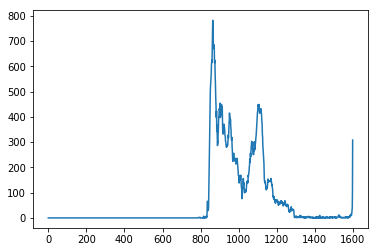

In [90]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 1)

plt.plot(np.arange(0,cube_sub.shape[1]), veg_by_row)

Text(0.5,1,'Built')

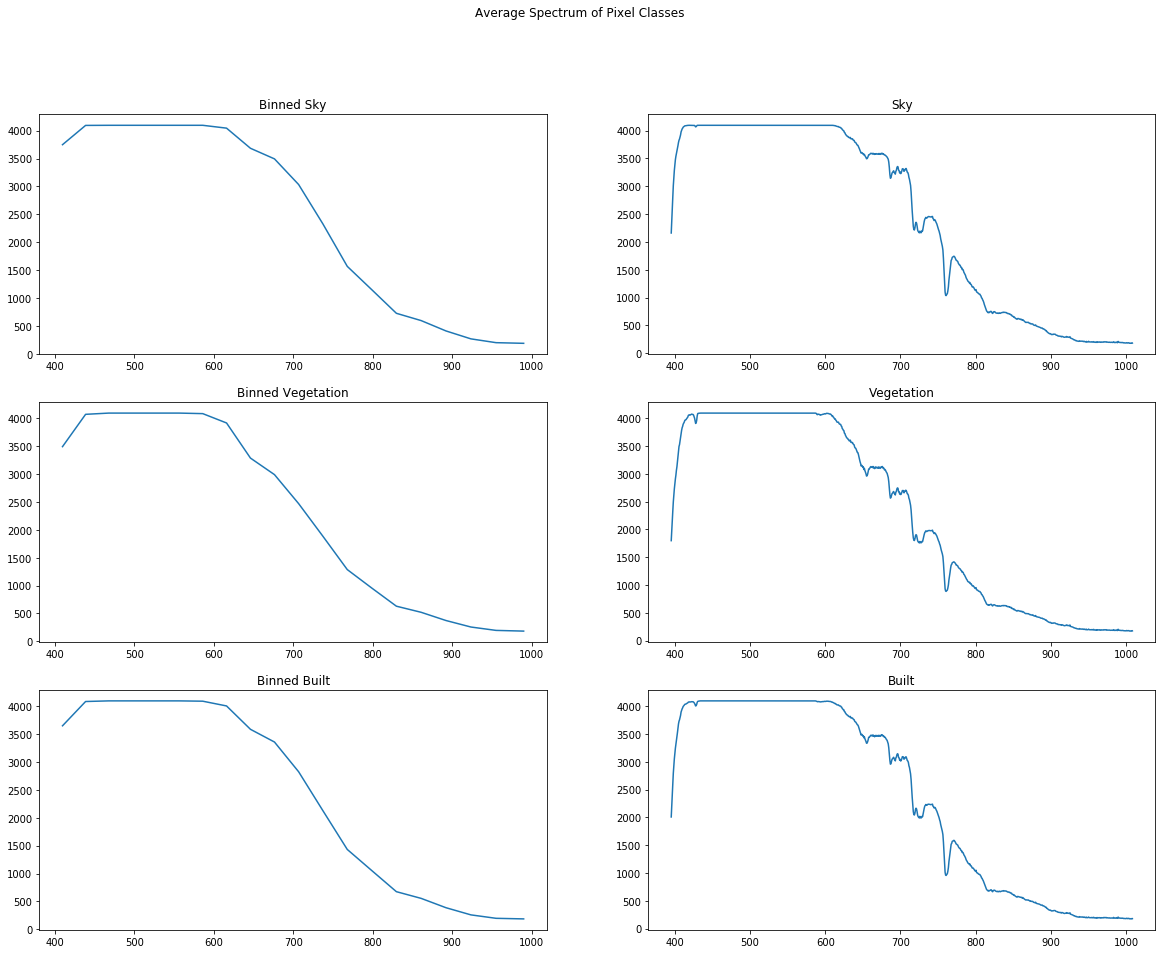

In [19]:
# plot specra for sky, vegetation and built

dtree_sky_ind = np.where(predictCube_reshape == 0)[0]
dtree_veg_ind = np.where(predictCube_reshape == 1)[0]
dtree_built_ind = np.where(predictCube_reshape == 2)[0]

avg_sky_binned_spectrum = cube_binned[dtree_sky_ind, :].mean(0)
avg_sky_spectrum = cube_reshaped[dtree_sky_ind, :].mean(0)
avg_veg_binned_spectrum = cube_binned[dtree_veg_ind, :].mean(0)
avg_veg_spectrum = cube_reshaped[dtree_veg_ind, :].mean(0)
avg_built_binned_spectrum = cube_binned[dtree_built_ind, :].mean(0)
avg_built_spectrum = cube_reshaped[dtree_built_ind, :].mean(0)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (20, 15))
plt.suptitle("Average Spectrum of Pixel Classes")
ax1.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_sky_binned_spectrum)
ax1.set_title('Binned Sky')
ax2.plot(cube.waves, avg_sky_spectrum)
ax2.set_title('Sky')
ax3.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_veg_binned_spectrum)
ax3.set_title('Binned Vegetation')
ax4.plot(cube.waves, avg_veg_spectrum)
ax4.set_title('Vegetation')
ax5.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_built_binned_spectrum)
ax5.set_title('Binned Built')
ax6.plot(cube.waves, avg_built_spectrum)
ax6.set_title('Built')

In [20]:
min_sky_spectrum = min(avg_sky_spectrum)
print(min_sky_spectrum)
avg_sky_spectrum = avg_sky_spectrum - min_sky_spectrum

178.2249123683295


In [21]:
# plot reflectance for sky, vegetation and built

reflectance = np.divide(cube_reshaped, avg_sky_spectrum[None, :], out=np.zeros_like(cube_reshaped), where=avg_sky_spectrum[None, :]!=0)
binned_reflectance = np.divide(cube_binned, avg_sky_binned_spectrum[None, :], out=np.zeros_like(cube_binned), where=avg_sky_binned_spectrum[None, :]!=0)

Text(0.5,1,'Built Reflectance')

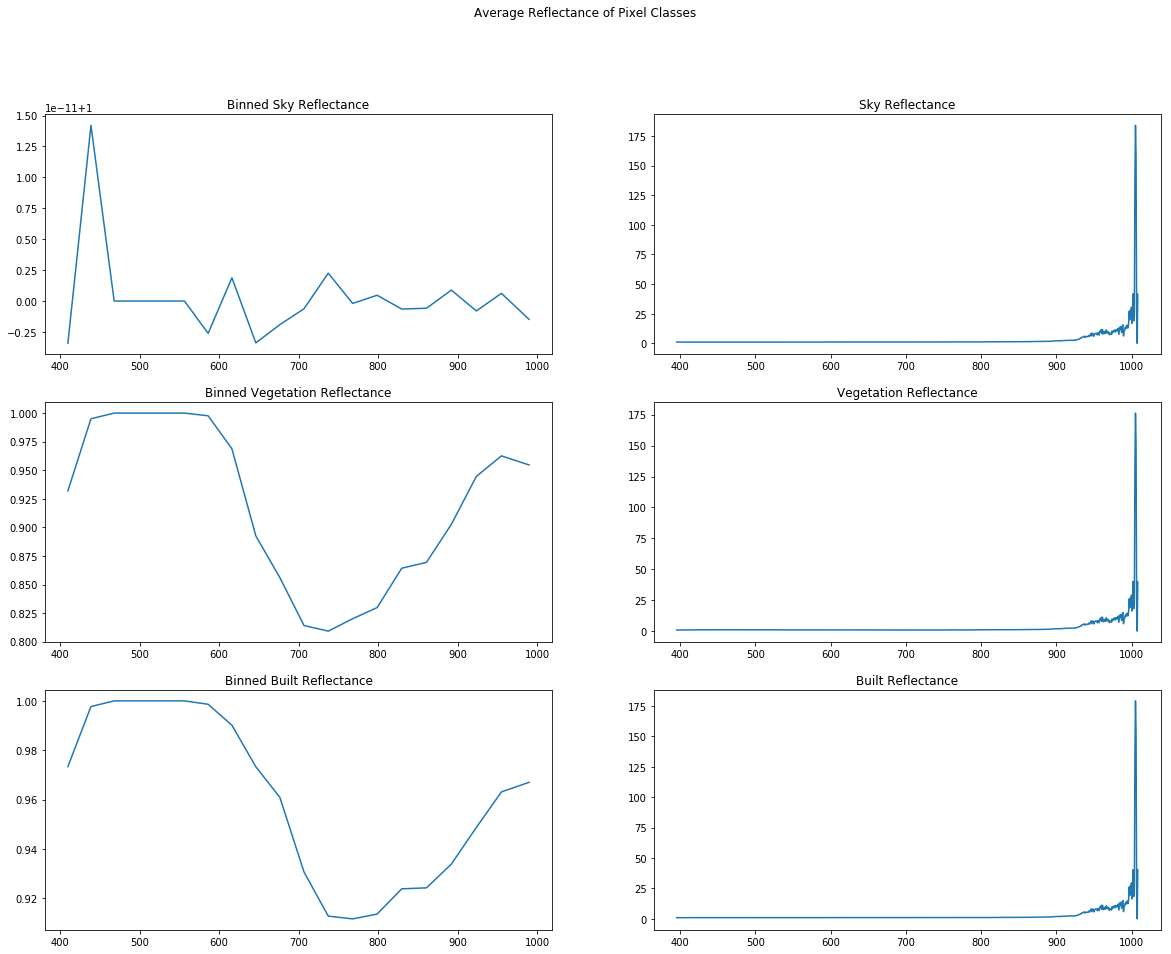

In [22]:
avg_sky_binned_reflect = binned_reflectance[dtree_sky_ind, :].mean(0)
avg_sky_reflect = reflectance[dtree_sky_ind, :].mean(0)
avg_veg_binned_reflect = binned_reflectance[dtree_veg_ind, :].mean(0)
avg_veg_reflect = reflectance[dtree_veg_ind, :].mean(0)
avg_built_binned_reflect = binned_reflectance[dtree_built_ind, :].mean(0)
avg_built_reflect = reflectance[dtree_built_ind, :].mean(0)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (20, 15))
plt.suptitle("Average Reflectance of Pixel Classes")
ax1.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_sky_binned_reflect)
ax1.set_title('Binned Sky Reflectance')
ax2.plot(cube.waves, avg_sky_reflect)
ax2.set_title('Sky Reflectance')
ax3.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_veg_binned_reflect)
ax3.set_title('Binned Vegetation Reflectance')
ax4.plot(cube.waves, avg_veg_reflect)
ax4.set_title('Vegetation Reflectance')
ax5.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_built_binned_reflect)
ax5.set_title('Binned Built Reflectance')
ax6.plot(cube.waves, avg_built_reflect)
ax6.set_title('Built Reflectance')

In [23]:
index_cut = (np.abs(cube.waves - 850.0)).argmin()
reflectance_sub = reflectance[:, :index_cut]

Text(0.5,1,'Built Reflectance')

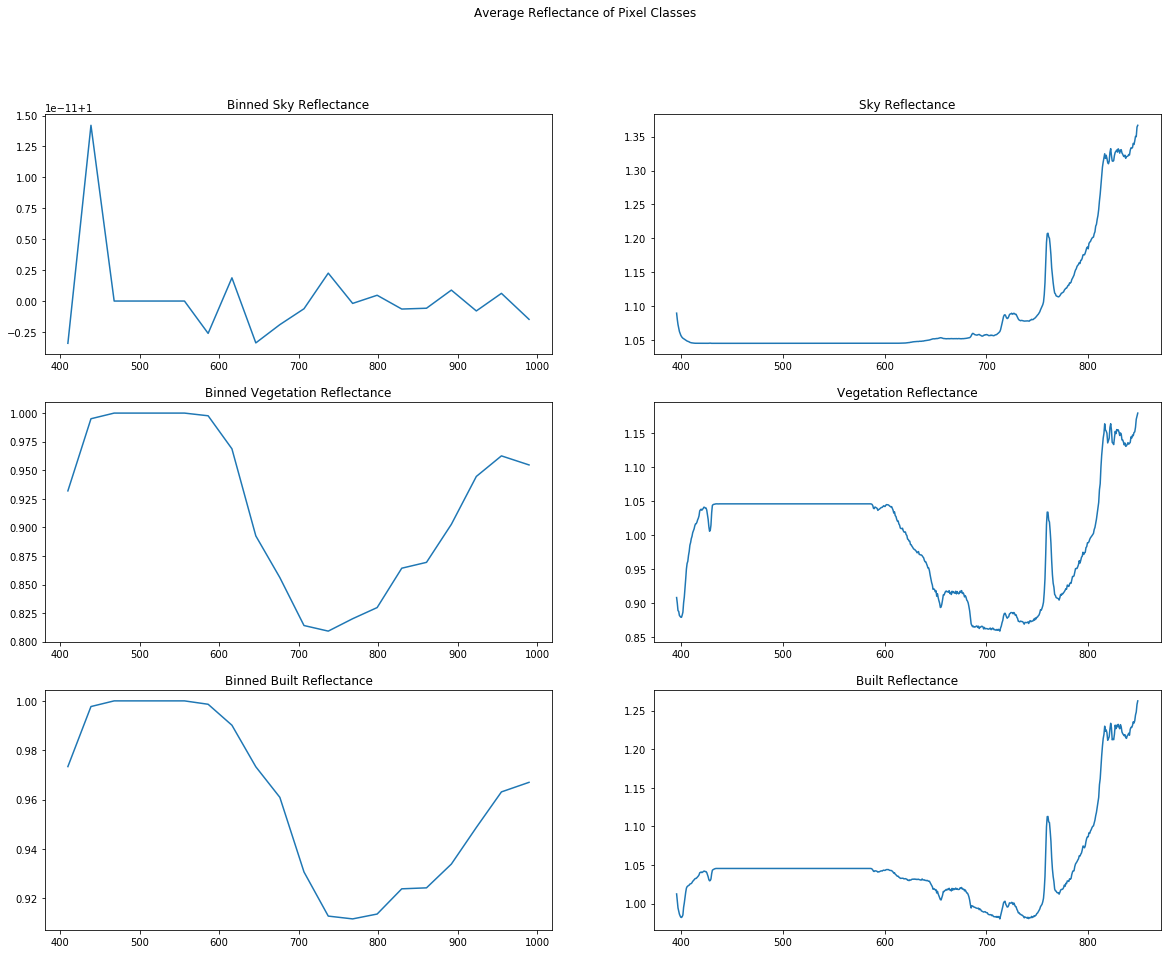

In [24]:
avg_sky_binned_reflect = binned_reflectance[dtree_sky_ind, :].mean(0)
avg_sky_reflect = reflectance_sub[dtree_sky_ind, :].mean(0)
avg_veg_binned_reflect = binned_reflectance[dtree_veg_ind, :].mean(0)
avg_veg_reflect = reflectance_sub[dtree_veg_ind, :].mean(0)
avg_built_binned_reflect = binned_reflectance[dtree_built_ind, :].mean(0)
avg_built_reflect = reflectance_sub[dtree_built_ind, :].mean(0)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (20, 15))
plt.suptitle("Average Reflectance of Pixel Classes")
ax1.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_sky_binned_reflect)
ax1.set_title('Binned Sky Reflectance')
ax2.plot(cube.waves[:index_cut], avg_sky_reflect)
ax2.set_title('Sky Reflectance')
ax3.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_veg_binned_reflect)
ax3.set_title('Binned Vegetation Reflectance')
ax4.plot(cube.waves[:index_cut], avg_veg_reflect)
ax4.set_title('Vegetation Reflectance')
ax5.plot(cube.waves[np.array(bin_ind).mean(1).astype(int)], avg_built_binned_reflect)
ax5.set_title('Binned Built Reflectance')
ax6.plot(cube.waves[:index_cut], avg_built_reflect)
ax6.set_title('Built Reflectance')

### Test 108 model on 000 image

In [91]:
fname0 = "../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../image_files/veg_00000.hdr...
reading ../image_files/veg_00000.raw...


In [92]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [93]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


In [94]:
cube_binned0 = np.zeros(shape=(cube_reshaped0.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binned0[:, i] = cube_reshaped0[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binned0.shape)

(2560000, 20)


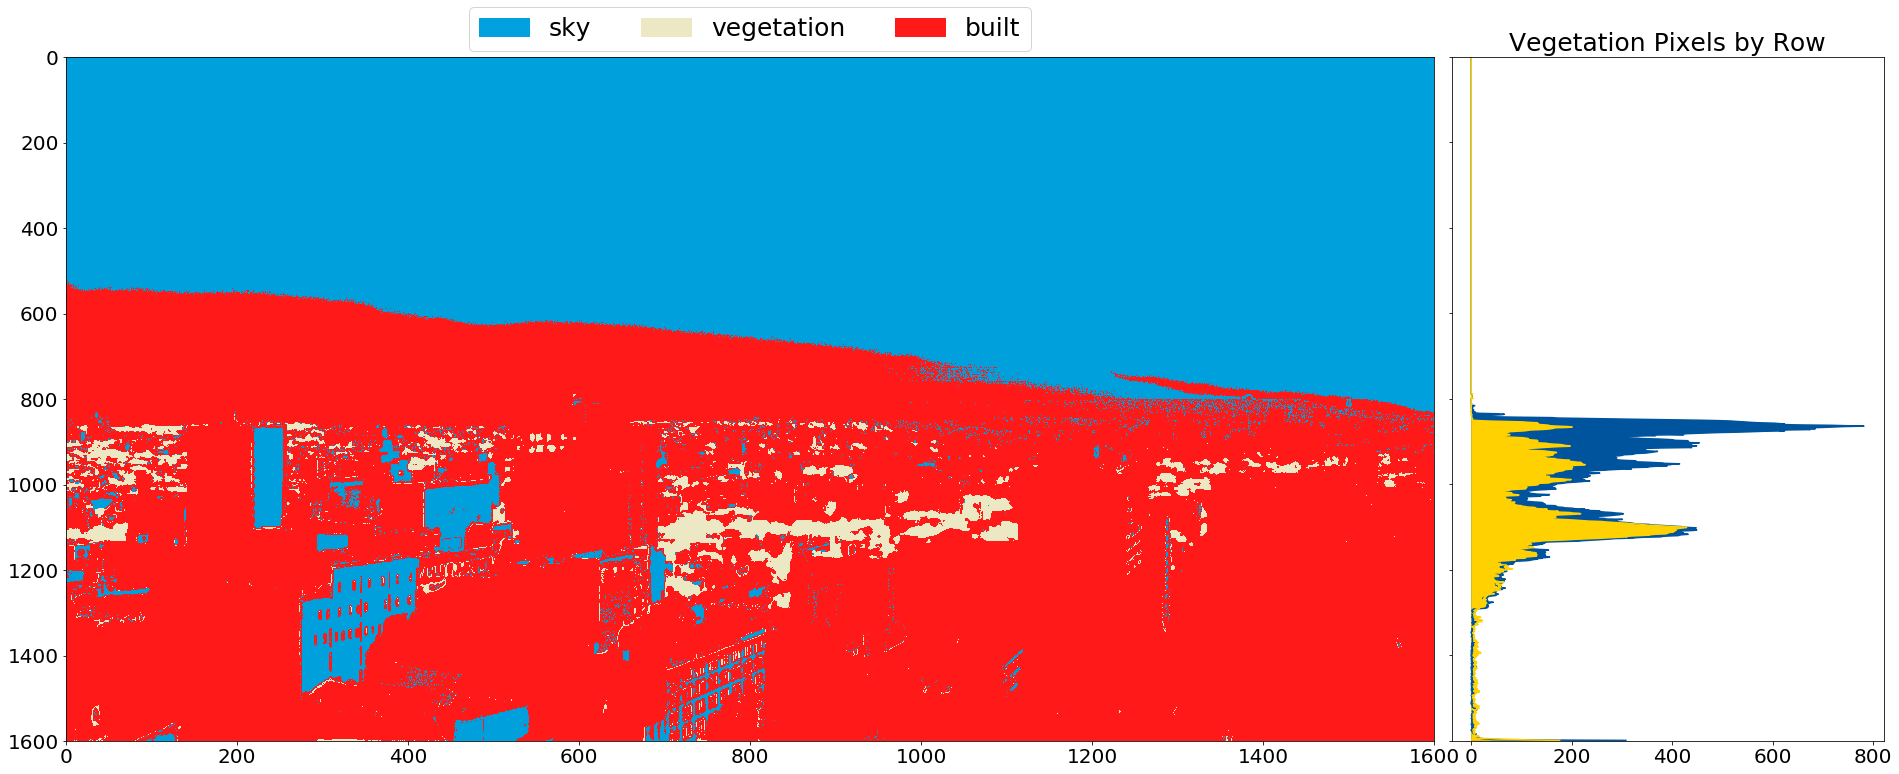

In [220]:
# test 108 model on 000 image

testModel108_on000 = dTree.predict(cube_binned0)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline

testModel108_on000_reshape = testModel108_on000.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

veg_by_row_0 = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row_0[row] = np.count_nonzero(testModel108_on000_reshape[row,:] == 1)

t=1
cmap = {0:[0.0,0.63,0.87,t], 1:[0.93,0.91,0.77,t], 2:[1.0,0.1,0.1,t]}
labels = {0:'sky', 1:"vegetation", 2:"built"}
arrayShow = np.array([[cmap[i] for i in j] for j in testModel108_on000_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(1, figsize = (30, 10))
axImage = plt.axes([0.1,0.1,0.65,0.95])
axHist = plt.axes([0.75,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0.5,1), loc=9, borderaxespad=-2.0, prop={'size':25}, ncol=3)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])    
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.plot(veg_by_row_0, np.arange(0,cube_sub.shape[1]), color=[1.0, 0.82,0.0])    
axHist.fill_between(veg_by_row_0, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[1.0, 0.82,0.0])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
plt.show()
fig.savefig("./output/plots/5_decision_tree_classification_tested_on_veg_00000.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [97]:
# function to read coordinates from file

def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [98]:
# read manually selected coordinates files

# sky coordinates
sky_file0 = open("./sky_coordinates_000.txt", "r")
sky_coords0 = sky_file0.readlines()
sky_file0.close()
sky_coords0 = np.array([point_from_string(line) for line in sky_coords0])
print(sky_coords0.shape)

# vegetation coordinates
veg_file0 = open("./vegetation_coordinates_000.txt", "r")
veg_coords0 = veg_file0.readlines()
veg_file0.close()
veg_coords0 = np.array([point_from_string(line) for line in veg_coords0])
print(veg_coords0.shape)

# built coordinates
built_file0 = open("./built_coordinates_000.txt", "r")
built_coords0 = built_file0.readlines()
built_file0.close()
built_coords0 = np.array([point_from_string(line) for line in built_coords0])
print(built_coords0.shape)

(1010, 2)
(610, 2)
(1210, 2)


In [99]:
import collections, numpy

unique_sky0, counts_sky0 = numpy.unique(testModel108_on000_reshape[sky_coords0[:,0], sky_coords0[:,1]], return_counts=True)
counts_sky_norm0 = (counts_sky0/sky_coords0.shape[0])*100
sky_dict0 = dict(zip(unique_sky0, counts_sky0))
sky_dict_norm0 = dict(zip(unique_sky0, counts_sky_norm0))

unique_veg0, counts_veg0 = numpy.unique(testModel108_on000_reshape[veg_coords0[:,0], veg_coords0[:,1]], return_counts=True)
counts_veg_norm0 = (counts_veg0/veg_coords0.shape[0])*100
veg_dict0 = dict(zip(unique_veg0, counts_veg0))
veg_dict_norm0 = dict(zip(unique_veg0, counts_veg_norm0))

unique_blt0, counts_blt0 = numpy.unique(testModel108_on000_reshape[built_coords0[:,0], built_coords0[:,1]], return_counts=True)
counts_blt_norm0 = (counts_blt0/built_coords0.shape[0])*100
blt_dict0 = dict(zip(unique_blt0, counts_blt0))
blt_dict_norm0 = dict(zip(unique_blt0, counts_blt_norm0))

In [100]:
for i in range(0,3):
    if sky_dict0.get(i) is None: sky_dict0[i] = 0
    if veg_dict0.get(i) is None: veg_dict0[i] = 0
    if blt_dict0.get(i) is None: blt_dict0[i] = 0
    if sky_dict_norm0.get(i) is None: sky_dict_norm0[i] = 0
    if veg_dict_norm0.get(i) is None: veg_dict_norm0[i] = 0
    if blt_dict_norm0.get(i) is None: blt_dict_norm0[i] = 0

In [101]:
import pandas as pd

pixel_names = ['sky', 'vegetation', 'built']
df_test0 = pd.DataFrame([sky_dict0, veg_dict0, blt_dict0], index=pixel_names)
df_test0 = df_test0.transpose()
print(df_test0)

   sky  vegetation  built
0  795           2    143
1    0         563     10
2  215          45   1057


In [102]:
import pandas as pd

pixel_names = ['sky', 'vegetation', 'built']
df_test_norm0 = pd.DataFrame([sky_dict_norm0, veg_dict_norm0, blt_dict_norm0], index=pixel_names)
df_test_norm0 = df_test_norm0.transpose()
print(df_test_norm0)

         sky  vegetation      built
0  78.712871    0.327869  11.818182
1   0.000000   92.295082   0.826446
2  21.287129    7.377049  87.355372


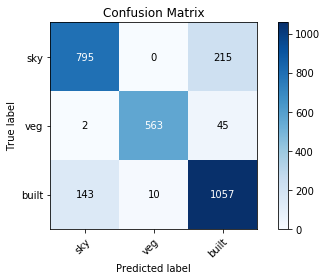

In [103]:
cm0 = np.array([df_test0['sky'].values, df_test0['vegetation'].values, df_test0['built'].values])
classes = ['sky', 'veg', 'built']

fig, ax = plt.subplots()
im = ax.imshow(cm0, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm0.shape[1]),
      yticks=np.arange(cm0.shape[0]),
      xticklabels=classes, yticklabels=classes,
      title='Confusion Matrix',
      ylabel='True label',
      xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")
#fmt = '.2f'
thresh = cm0.max() / 2
for i in range(cm0.shape[0]):
    for j in range(cm0.shape[1]):
        ax.text(j, i, format(cm0[i, j]),
               ha="center", va="center",
               color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()
fig.savefig("./output/plots/6_decision_tree_confusion_matrix_of_veg_00000.png")

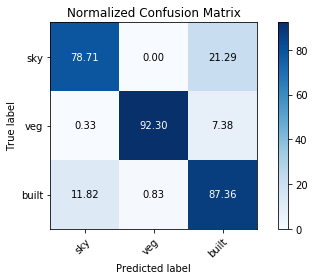

In [104]:
cm_norm0 = np.array([df_test_norm0['sky'].values, df_test_norm0['vegetation'].values, df_test_norm0['built'].values])
classes = ['sky', 'veg', 'built']

fig, ax = plt.subplots()
im = ax.imshow(cm_norm0, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm_norm0.shape[1]),
      yticks=np.arange(cm_norm0.shape[0]),
      xticklabels=classes, yticklabels=classes,
      title='Normalized Confusion Matrix',
      ylabel='True label',
      xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")
fmt = '.2f'
thresh = cm_norm0.max() / 2
for i in range(cm_norm0.shape[0]):
    for j in range(cm_norm0.shape[1]):
        ax.text(j, i, format(cm_norm0[i, j], fmt),
               ha="center", va="center",
               color="white" if cm_norm0[i, j] > thresh else "black")
fig.tight_layout()
plt.show()
fig.savefig("./output/plots/7_decision_tree_norm_confusion_matrix_of_veg_00000.png")

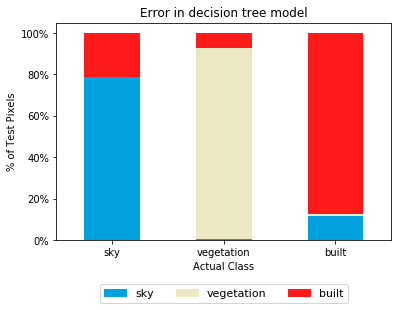

In [219]:
df_test_norm0 = df_test_norm0.transpose()
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

ax = df_test_norm0.plot.bar(rot=0, stacked=True, color=[[0.0,0.63,0.87,1.0], [0.93,0.91,0.77,1.0], [1.0,0.1,0.1,1.0]])
formatter = FuncFormatter(lambda counts_veg_norm0, pos: "%d%%" % (counts_veg_norm0))
ax.yaxis.set_major_formatter(formatter)
plt.xlabel('Actual Class')
plt.ylabel('% of Test Pixels')
#plt.title('Decision Tree trained on veg_00108 tested on veg_00000')
plt.title('Error in decision tree model')
lgd = ax.legend(handles=patches, bbox_to_anchor=(0.5,0), loc=9, borderaxespad=4.0, prop={'size':11}, ncol=3)
#plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
#plt.show()
plt.savefig("./output/plots/8_decision_tree_class_prediction_error_of_veg_00000.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

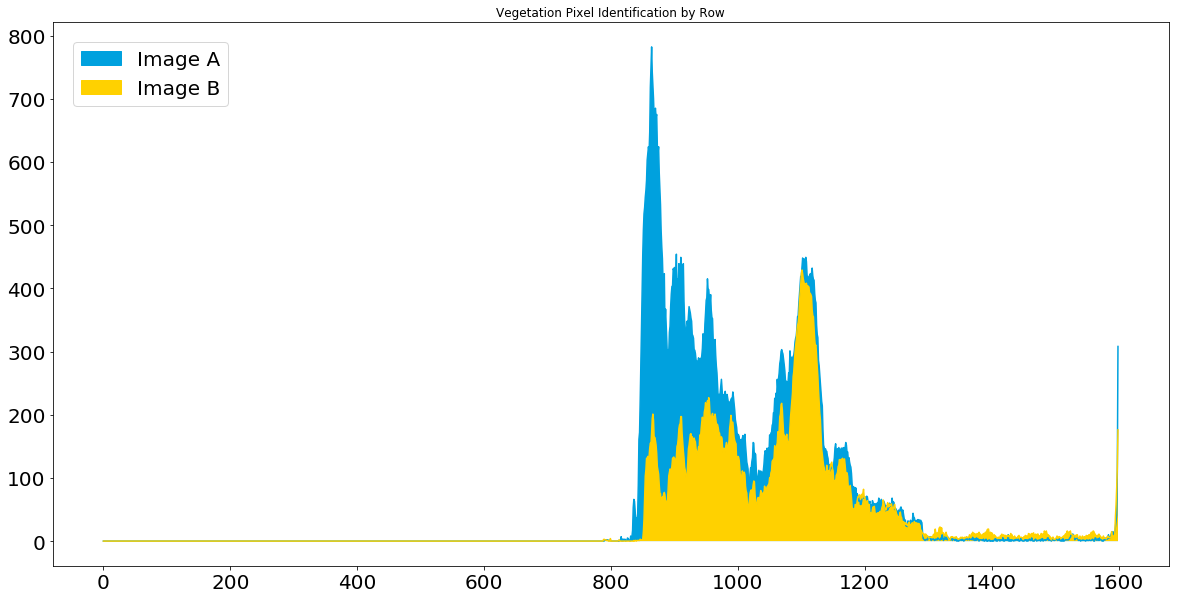

In [172]:
veg_by_row_0 = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row_0[row] = np.count_nonzero(testModel108_on000_reshape[row,:] == 1)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

patch1 = mpatches.Patch(color=[0.0,0.63,0.87,1.0], label='Image A')
patch2 = mpatches.Patch(color=[1.0, 0.82,0.0,1.0], label='Image B')
fig, ax = plt.subplots(figsize = (20, 10))
plt.plot(np.arange(0,cube_sub.shape[1]), veg_by_row, color=[0.0,0.63,0.87])    
plt.plot(np.arange(0,cube_sub.shape[1]), veg_by_row_0, color=[1.0, 0.82,0.0])
plt.fill_between(np.arange(0,cube_sub.shape[1]), 0, veg_by_row, facecolor=[0.0, 0.63, 0.87])    
plt.fill_between(np.arange(0,cube_sub.shape[1]), 0, veg_by_row_0, facecolor=[1.0, 0.82,0.0])
ax.tick_params(labelsize=20)
lgd=plt.legend(handles=[patch1, patch2], loc=2, borderaxespad=1.0, prop={'size':20})
plt.title('Vegetation Pixel Identification by Row')
fig.savefig("./output/plots/15_decision_tree_vegetation_by_row_comparison.png", bbox_extra_artists=(lgd,), bbox_inches='tight')